In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('paths_finished.tsv', sep='\t')

In [3]:
df.shape

(51318, 5)

In [4]:
df.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


## Let us do a little bit of EDA

In [5]:
df.path[0]

'14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_trade;African_slave_trade'

In [6]:
transactions = df['path']

In [7]:
from urllib.parse import unquote
transactions = transactions.apply(unquote)
transactions = transactions.apply(lambda s : s.split(';'))

In [8]:
df = transactions.to_frame()

In [9]:
df['path len'] = transactions.apply(lambda l : len(l))

In [10]:
df['path len'].describe()

count    51318.000000
mean         6.757434
std          4.680718
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path len, dtype: float64

<AxesSubplot:ylabel='path len'>

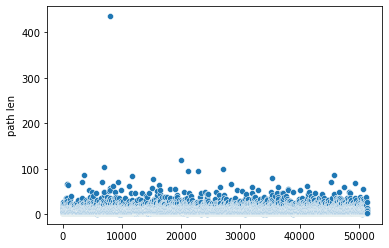

In [11]:
sns.scatterplot(y = df['path len'], x = df.index)

In [12]:
# remove outliers
df = df[df['path len'] < 30]

<AxesSubplot:ylabel='path len'>

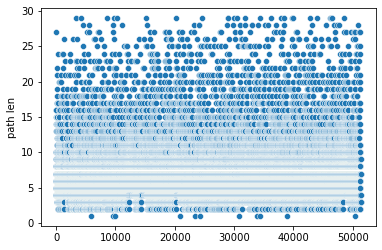

In [13]:
sns.scatterplot(y = df['path len'], x = df.index)

In [14]:
df.shape # we have removed about 300 element, yet the element distribution is way better now

(51072, 2)

{'whiskers': [<matplotlib.lines.Line2D at 0x22c8a3220c8>,
 'caps': [<matplotlib.lines.Line2D at 0x22c8a34bd48>,
 'boxes': [<matplotlib.lines.Line2D at 0x22c8a322508>],
 'medians': [<matplotlib.lines.Line2D at 0x22c8a34fa88>],
 'fliers': [<matplotlib.lines.Line2D at 0x22c8a34fac8>],
 'means': []}

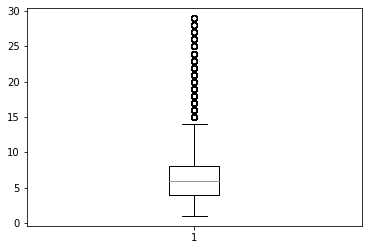

In [15]:
plt.boxplot(x=df['path len'])

In [16]:
lang = {}
for path in df['path']:
    for item in path:
        if item in lang.keys():
            lang[item] = lang[item] + 1
        else:
            lang[item] = 1

In [17]:
lang = pd.DataFrame(index=lang.keys(), data=lang.values(), columns=['count'])
lang.shape

(4169, 1)

In [18]:
lang.sort_values('count', ascending=False, inplace=True)
lang.head(10)

,count
<,17583
United_States,8744
Europe,4300
United_Kingdom,3839
England,3288
Earth,3184
Africa,2759
World_War_II,2273
North_America,1849
Germany,1754


In [19]:
def plot_freq_bar(x, y, title, scale='linear', figsize=(10, 5), rotation=True, xlabel='', ylabel=''):
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.barplot(x=x, y=y, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    if rotation:
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.yscale(scale)

    plt.grid()

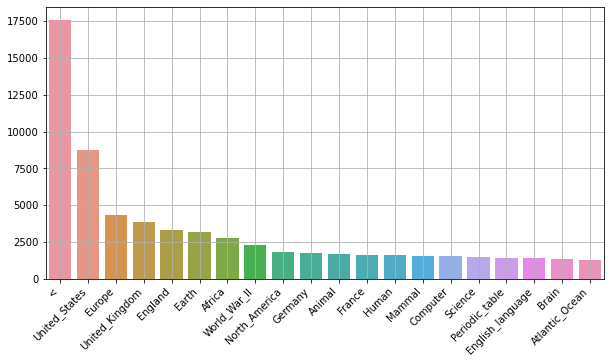

In [20]:
data = lang['count'][:20]
plot_freq_bar(x=data.index, y=data, title='', rotation=True)

# Let's get our hands dirty
<img src="imgs/its-a-dirty-6f8c09b7d7.jpg" width="600" height="300">

In [21]:
# we will encode article names for the ease of computation and the work with numbers
# this is faster than using sklearn label encoder (don't know why!)
rev_id_dict = lang.reset_index()['index']
id_dict = lang.reset_index().to_dict()['index']
id_dict = dict(zip(id_dict.values(), id_dict.keys()))

df['path'] = df['path'].apply(lambda x : [id_dict[item] for item in x])

In [22]:
db = df['path'].to_list()

In [23]:
# small test-case data base
# db = [
#     [1, 1, 2, 3, 1, 3, 3],
#     [1, 3, 2, 3],
#     [1, 2, 4, 3, 2, 3],
#     [1, 3, 2, 3],
# ]

In [24]:
# we use the lookup table (list) to calculate the projected DB on the fly
# for each sequence we keep track of it's index and a suffix offset
# this approach is called pseudo-projection (fast and much less memeory consuming)

# this function can't handle brackets yet! but too efficient for our sequence database
def discover(prefix, lookup_table, min_sup):
    items_occurs = dict()

    for seq_idx, current_pointer in lookup_table:
        # for each sequence in the (projected) DB
        seq = db[seq_idx]
        unique = set(seq[current_pointer + 1 :])
    
        for offset in range(current_pointer + 1, len(seq)):
            item = seq[offset]
            # add element occurence only once
            if item in unique:
                
                if item in items_occurs.keys():              
                    items_occurs[item].append((seq_idx, offset))
                else:
                    items_occurs[item] = [(seq_idx, offset)]

                unique.remove(item)
    
    res = [] if not prefix else [(len(lookup_table), prefix)]
    
    for item, occurs in items_occurs.items():
        if len(occurs) >= min_sup:
            # generate the new prefix and recursivly discover patterns
            res.extend(discover(prefix + (item,), occurs, min_sup))
    
    return res

In [25]:
import time
begin = time.time()
res = discover(tuple(), [(i, -1) for i in range(len(db))], 10)
print(f'{time.time() - begin:0.2}')

2.4


In [26]:
res.sort(key=lambda x : x[0], reverse=True)

In [27]:
len(res)

36036

In [28]:
# decode names and calcluate reletive support
ans = [(f'{sup*100/len(db):0.3}%', tuple(map(lambda x : rev_id_dict[x], seq))) for sup, seq in res]

In [29]:
ans

[('17.2%', ('<',)),
 ('16.8%', ('United_States',)),
 ('8.34%', ('Europe',)),
 ('7.36%', ('United_Kingdom',)),
 ('7.23%', ('<', '<')),
 ('6.31%', ('England',)),
 ('6.15%', ('Earth',)),
 ('5.31%', ('Africa',)),
 ('4.39%', ('World_War_II',)),
 ('3.87%', ('<', '<', '<')),
 ('3.58%', ('North_America',)),
 ('3.38%', ('Germany',)),
 ('3.2%', ('Animal',)),
 ('3.07%', ('France',)),
 ('3.06%', ('Human',)),
 ('3.01%', ('Mammal',)),
 ('2.96%', ('Computer',)),
 ('2.84%', ('Science',)),
 ('2.72%', ('Periodic_table',)),
 ('2.72%', ('English_language',)),
 ('2.56%', ('Brain',)),
 ('2.5%', ('United_States', '<')),
 ('2.48%', ('Atlantic_Ocean',)),
 ('2.44%', ('Telephone',)),
 ('2.35%', ('India',)),
 ('2.33%', ('Viking',)),
 ('2.29%', ('Bird',)),
 ('2.29%', ('<', '<', '<', '<')),
 ('2.28%', ('Asteroid',)),
 ('2.27%', ('Asia',)),
 ('2.19%', ('Agriculture',)),
 ('2.16%', ('China',)),
 ('2.14%', ('Plant',)),
 ('2.06%', ('Japan',)),
 ('2.05%', ('Christianity',)),
 ('2.04%', ('Brain', 'Telephone')),
 ('2.04%'

In [30]:
db1 = [
    [1, (1, 2, 3), (1, 3), 4, (3, 6)],
    [(1, 4), 3, (2, 3), (1, 5)],
    [(5, 6), (1, 2), (4, 6), 3, 2],
    [5, 7, (1, 6), 3, 2, 3]
]

In [33]:
from collections import defaultdict

# too bad time/memory complelxity!! like it take forever to finish :)
def calc_frequent(sdb, min_sup):
    items_occurs = defaultdict(int)

    frequent_items = []
    
    for seq in sdb:

        se = set()

        for item in seq:
            if isinstance(item, tuple):
                for sub_item in item:
                    if sub_item not in se and sub_item != -1:
                        items_occurs[sub_item] = items_occurs[sub_item] + 1
                        se.add(sub_item)
            else:
                if item not in se:
                    items_occurs[item] = items_occurs[item] + 1
                    se.add(item)

    for item, occurs in items_occurs.items():
        if occurs >= min_sup:
            frequent_items.append((item, occurs))

    return frequent_items


def project(sdb, alpha):
    projection = []
    for seq in sdb:
        pp = []
        for idx, item in enumerate(seq):
            if isinstance(item, tuple):
                if alpha in item:
                    generate = True
                else:
                    generate = False
            else:
                if item == alpha:
                    generate = True
                else:
                    generate = False

            if generate:
                if isinstance(item, tuple):
                    if alpha in item:
                        pp = seq[idx:]
                        x = (-1,)
                        for sub_item in item:
                            if sub_item != alpha:
                                x = x + (sub_item,)
                        pp[0] = x

                        if len(set(x)) == 1:  # all element were taken from the brakets
                            pp = pp[1:]
                        break
                else:
                    pp = seq[idx + 1:]
                    break
        if pp:
            projection.append(pp)
    return projection


res1 = []
def discover1(prefix, sdb, min_sup):
    frequent_items = calc_frequent(sdb, min_sup)
    for item, sup in frequent_items:
        # assemble/append to prefix
        new_prefix = prefix + (item,)

        # project sdb on item
        new_sdb = project(sdb, item)

        # recursively discover patterns
        res1.append((new_prefix, sup))

        discover1(new_prefix, new_sdb, min_sup)

<img src="imgs/meme.webp" width="350" height="300">

In [34]:
res1 = []
begin = time.time()
discover1(tuple(), db, 10)
print(f'{time.time() - begin:0.2}')
res1

2.8e+02


[((419,), 147),
 ((419, 318), 18),
 ((419, 318, 272), 11),
 ((419, 272), 13),
 ((419, 337), 17),
 ((419, 337, 797), 15),
 ((419, 178), 10),
 ((419, 178, 797), 10),
 ((419, 264), 10),
 ((419, 264, 797), 10),
 ((419, 797), 27),
 ((419, 0), 22),
 ((419, 0, 0), 10),
 ((419, 598), 20),
 ((419, 598, 704), 13),
 ((419, 556), 31),
 ((419, 556, 598), 18),
 ((419, 556, 598, 704), 13),
 ((419, 556, 704), 13),
 ((419, 556, 22), 11),
 ((419, 467), 37),
 ((419, 467, 556), 30),
 ((419, 467, 556, 598), 18),
 ((419, 467, 556, 598, 704), 13),
 ((419, 467, 556, 704), 13),
 ((419, 467, 556, 22), 11),
 ((419, 467, 598), 18),
 ((419, 467, 598, 704), 13),
 ((419, 467, 704), 13),
 ((419, 467, 22), 11),
 ((419, 492), 55),
 ((419, 492, 467), 35),
 ((419, 492, 467, 556), 30),
 ((419, 492, 467, 556, 598), 18),
 ((419, 492, 467, 556, 598, 704), 13),
 ((419, 492, 467, 556, 704), 13),
 ((419, 492, 467, 556, 22), 11),
 ((419, 492, 467, 598), 18),
 ((419, 492, 467, 598, 704), 13),
 ((419, 492, 467, 704), 13),
 ((419, 

In [35]:
print(len(res))
print(len(res1))

36036
36036
